In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns

from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_erode as cerd
from thalamus_merfish_analysis import diversity_metrics as divmet
from thalamus_merfish_analysis import diversity_plots as dplot
import thalamus_merfish_analysis.distance_metrics as dm
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 9


## Load thalamus data

In [4]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

In [7]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [8]:
# 3 example sections for paper figures
sections_3 = [6.4, 7.2, 8.0]

In [9]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names('substructure')

In [10]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
# palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() #dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

## Figure 1: Thalamic cell types vs anatomical annotations

### Figure 1(a): Subset of ABC Atlas

/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:906: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


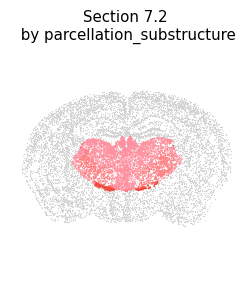

In [11]:
# downsample non-TH cells to minimize num of points rendered
obs_nonTH = obs_wmb.drop(obs_th.index, axis=0)
obs_nonTH = obs_nonTH.sample(frac=0.1, random_state=0)

kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=obs_nonTH, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='white',
                        point_size=1, # cell marker size
                       )


taxonomy_level = 'class'
subset_fig = cplots.plot_ccf_overlay(
    obs_th.sample(frac=0.5, random_state=0), 
    ccf_images, 
    point_hue='parcellation_substructure',
    sections=[sections_3[1]],
    separate_figs=True, # False does NOT show bg_cells
    point_palette=ccf_palette,#abc_palettes[taxonomy_level],
    legend=None, #'cells',
    figsize=(20, 5),
    custom_xy_lims=[0, 11, 11, 0],
    **kwargs_celltypes
)
subset_fig[0].set_size_inches(3, 3)
subset_fig[0].savefig(f'../results/fig1A_subset_of_abc_atlas.pdf', 
                          transparent=True, bbox_inches='tight')

### Figure 1(b): Taxonomy tree

### Figure 1(c): ARA anatomical annotations 

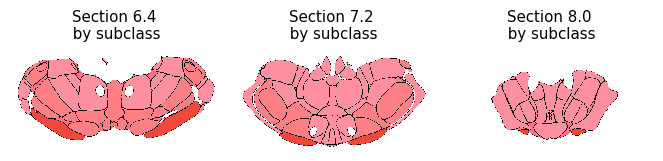

In [12]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0,
    edge_color="black",
    boundary_img=ccf_boundaries,
    # custom_xy_lims=[2.5, 6, 7, 4],
)

figs_ara = cplots.plot_ccf_overlay(
    obs_th.iloc[:1,:],
    ccf_images,
    point_hue="subclass",
    face_palette=ccf_palette, 
    min_group_count=0,
    sections=sections_3,
    separate_figs=False,
    figsize=(20, 5),
    legend=None,
    **kwargs,
)
figs_ara[0].set_size_inches(8.3, 3)
figs_ara[0].savefig(f'../results/fig1C_ccf_ara.png',
                 transparent=True, bbox_inches='tight', dpi=300)

### Figure 1(d-g): TH+ZI cell types

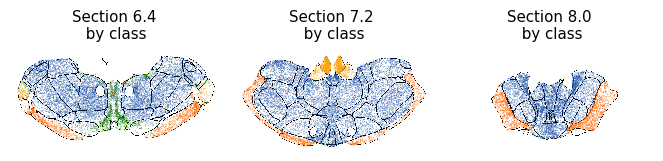

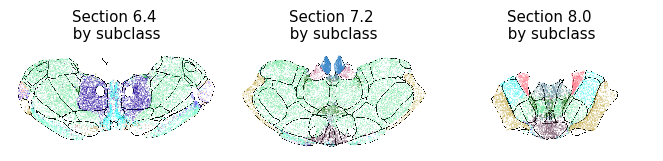

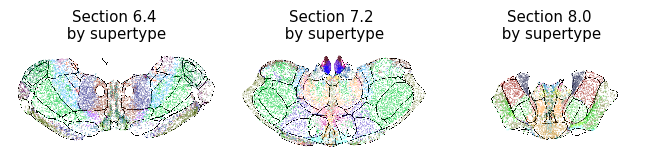

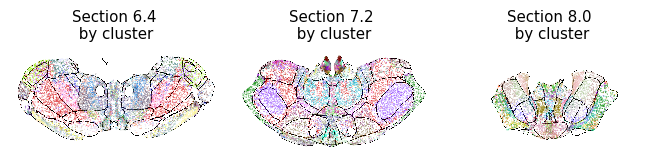

In [13]:
kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=None,#obs_wmb, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='black',
                        point_size=0.3, # cell marker size
                       )

levels = ['class', 'subclass', 'supertype', 'cluster']
fig_parts = ['D', 'E', 'F', 'G']

for i, taxonomy_level in enumerate(levels):
    palette = abc_palettes[taxonomy_level]
        
    figs_ccf_celltypes = cplots.plot_ccf_overlay(
        obs_th, 
        ccf_images, 
        point_hue=taxonomy_level, 
        sections=sections_3,
        separate_figs=False,
        point_palette=palette,
        legend=None, #'cells',
        figsize=(20, 5),
        **kwargs_celltypes
    )
    
    figs_ccf_celltypes[0].set_size_inches(8.3, 3)
    
    figs_ccf_celltypes[0].savefig(f'../results/fig1{fig_parts[i]}_ccf_{taxonomy_level}.pdf',
                                  transparent=True, bbox_inches='tight')

## Table 1: Taxonomy for TH+ZI cell types

In [14]:
taxonomy_levels = ['class', 'subclass', 'supertype', 'cluster']
obs_tax = obs_th.drop_duplicates(subset='cluster')[taxonomy_levels]

# Clean up the taxonomy columns for sorting
for col in obs_tax.columns:
    # only keep categories that are present in the TH+ZI dataset
    obs_tax.loc[:,col] = obs_tax.loc[:,col].cat.remove_unused_categories()
    # remove leading/trailing whitespace
    obs_tax.loc[:,col] = obs_tax.loc[:,col].str.strip()
    # extract the ID # b/c lexically sorting the str object doesn't yield correct order
    obs_tax.loc[:,col+'_id'] = obs_tax.loc[:,col].str.extract('(\d+)', expand=False).astype(float)

# sort by ID #s
num_cols = [x+'_id' for x in taxonomy_levels]
taxonomy_df = obs_tax.sort_values(by=num_cols, ascending=True, ignore_index=True)
# clean up the ID columns
taxonomy_df = taxonomy_df.drop(columns=num_cols)

display(taxonomy_df)

,class,subclass,supertype,cluster
0,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1580 RT-ZI Gnb3 Gaba_1
1,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1581 RT-ZI Gnb3 Gaba_1
2,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1582 RT-ZI Gnb3 Gaba_1
3,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1583 RT-ZI Gnb3 Gaba_1
4,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1584 RT-ZI Gnb3 Gaba_1
...,...,...,...,...
558,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3802 SCsg Gabrr2 Gaba_1
559,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3803 SCsg Gabrr2 Gaba_1
560,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3804 SCsg Gabrr2 Gaba_1
561,20 MB GABA,213 SCsg Gabrr2 Gaba,0873 SCsg Gabrr2 Gaba_2,3808 SCsg Gabrr2 Gaba_2


In [15]:
# Save out as csv file
taxonomy_df.to_csv('../results/th_zi_taxonomy_CCN20230722.csv', index=False)

## Figure 2: Thalamic nuclei metrics

In [17]:
obs_erode = cerd.label_cells_by_eroded_ccf(obs_th, ccf_images) # default is erosion by 5px (5um)
# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure

obs_erode.loc[lambda df: df['z_section']==6.6, cerd.ERODED_CCF_STRUCTURE_COL] = 'unassigned'

# generate metrics for the eroded CCF structure
ccf_label='parcellation_structure_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)

regions_to_plot = dplot.TH_DIVERSITY_REGIONS

### Fig S1: Stacked barplots

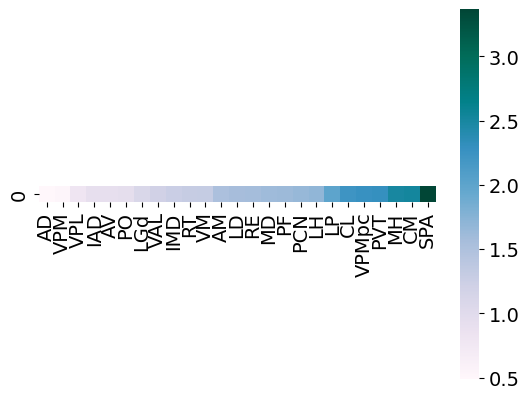

In [19]:
taxonomy_level = 'cluster'
metrics_to_sort_by = th_ccf_metrics.loc[dplot.TH_DIVERSITY_REGIONS,:]
isi_sorted_metrics = metrics_to_sort_by.sort_values(
                                by=[f'inverse_simpsons_{taxonomy_level}'], 
                                ascending=True
                                )
isi_sorted_regions = isi_sorted_metrics.index

# plot 
fig_isi_rank, ax = plt.subplots()
# log transforming just to make the colormap more divergent
sns.heatmap(np.log([isi_sorted_metrics[f'inverse_simpsons_{taxonomy_level}'].values]),
            square=True, cmap='PuBuGn',#'YlGnBu',
            xticklabels=isi_sorted_regions,
            ax=ax)

fig_isi_rank.savefig(f'../results/diversity_rank_1Dheatmap_isi_nuclei_vs_cluster.pdf', 
                     transparent=True, bbox_inches='tight')

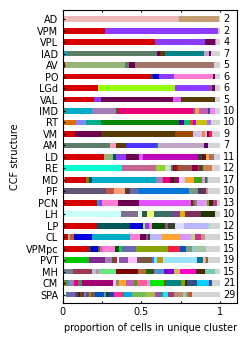

In [20]:
plt.rcParams.update({'font.size': 7})

# cluster
taxonomy_level = 'cluster'
fig_bp_cluster = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01,  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=isi_sorted_regions,
    orientation='horizontal',
)
fig_bp_cluster.set_size_inches(2.25,3.8)
fig_bp_cluster.gca().tick_params(length=0.02*72)

ax_cluster = fig_bp_cluster.gca()
xticklabels_cluster = [x.get_text() for x in ax_cluster.get_xticklabels()]

fig_bp_cluster.savefig(f'../results/nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}.pdf', 
                       transparent=True, bbox_inches='tight')

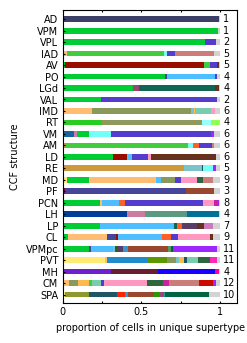

In [21]:
# supertype
taxonomy_level = 'supertype'
fig_bp_supertype = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01, # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=isi_sorted_regions,
    orientation='horizontal',
)
fig_bp_supertype.set_size_inches(2.25,3.8)
fig_bp_supertype.gca().tick_params(length=0.02*72)

# alternative: order the CCF regions for subclass & cluster plots using the 
# order of regions from sorting by supertype diversity
ax_supertype = fig_bp_supertype.gca()
xticklabels_supertype = [x.get_text() for x in ax_supertype.get_xticklabels()]

fig_bp_supertype.savefig(f'../results/nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}.pdf', 
                         transparent=True, bbox_inches='tight')

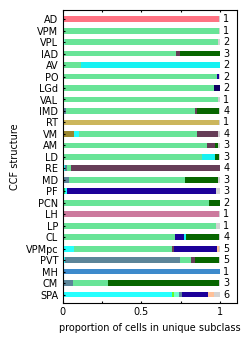

In [22]:
# subclass
taxonomy_level = 'subclass'
fig_bp_subclass = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01,  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=isi_sorted_regions,
    orientation='horizontal',
)
fig_bp_subclass.set_size_inches(2.25,3.8)
fig_bp_subclass.gca().tick_params(length=0.02*72)

ax_subclass = fig_bp_subclass.gca()
xticklabels_subclass = [x.get_text() for x in ax_subclass.get_xticklabels()]

fig_bp_subclass.savefig(f'../results/nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}.pdf', 
                        transparent=True, bbox_inches='tight')

### Fig 2A-C - 2D heatmaps

In [23]:
regions_final = [
    "AD", "AV", "AM", "IAD", "LD", "VPM", "VPL", "LGd",
    "MD", "CL", "CM", "IMD", "PO", "LP", "VAL", "VM", 
    "RE", "PF", "VPMpc", "PCN", "SPA", "PVT", "MH", "LH", "RT", 
]

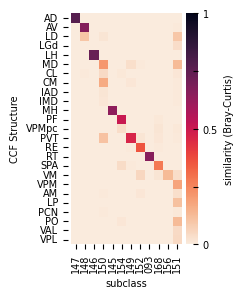

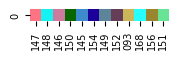

In [33]:
# ccf region order here is fairly arbitrary t
taxonomy_level = 'subclass'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_th, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=sorted(regions_final),
                            x_names=sorted(obs_th[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

x_names_ids_only = [name[0:3] for name in x_names]

plt.rcParams.update({'font.size': 7})
fig_hm_subclass = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names_ids_only)

fig_hm_subclass.set_size_inches(1.8,3)
fig_hm_subclass.gca().set_xlabel(taxonomy_level)
fig_hm_subclass.gca().set_ylabel('CCF Structure')

fig_hm_subclass.savefig(f'../results/similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
                        transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(1.8,3)
fig_xlabel_colors.savefig(f'../results/similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                        transparent=True, bbox_inches='tight')

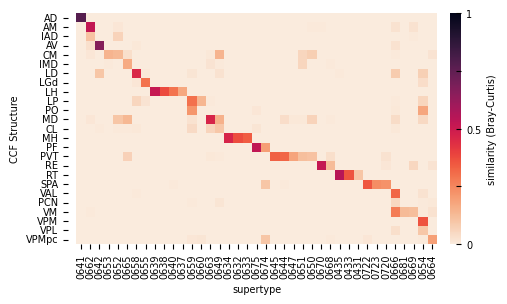

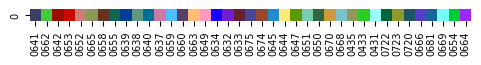

In [32]:
# ccf region order here is fairly arbitrary t
taxonomy_level = 'supertype'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_th, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=sorted(regions_final),
                            x_names=sorted(obs_th[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

x_names_ids_only = [name[0:4] for name in x_names]

fig_hm_supertype = dm.plot_ordered_similarity_heatmap(
                        dist, 
                        y_order=y_order, x_order=x_order, 
                        y_names=y_names, x_names=x_names_ids_only
                        )

fig_hm_supertype.set_size_inches(5.8,3)
fig_hm_supertype.gca().set_xlabel(taxonomy_level)
fig_hm_supertype.gca().set_ylabel('CCF Structure')


fig_hm_supertype.savefig(f'../results/similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
                        transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(5.7,3)
fig_xlabel_colors.savefig(f'../results/similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                          transparent=True, bbox_inches='tight')

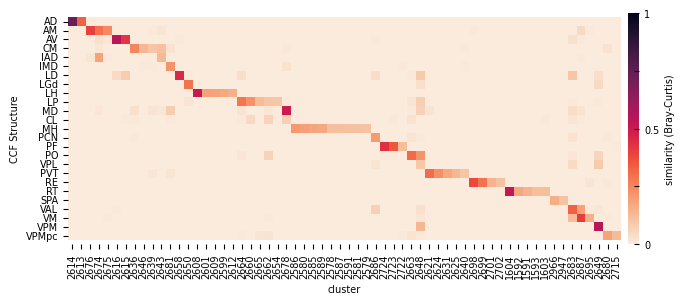

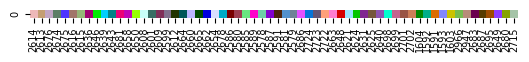

In [31]:
taxonomy_level = 'cluster'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_th, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=sorted(regions_final),
                            x_names=sorted(obs_th[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

x_names_ids_only = [name[0:4] for name in x_names]

fig_hm_cluster = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names_ids_only)

fig_hm_cluster.set_size_inches(8.5,3)
fig_hm_cluster.gca().set_xlabel(taxonomy_level)
fig_hm_cluster.gca().set_ylabel('CCF Structure')


fig_hm_cluster.savefig(f'../results/similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
                        transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(6.3,3)
fig_xlabel_colors.savefig(f'../results/similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                          transparent=True, bbox_inches='tight')

### Figure 2D-E: Diversity metrics in space

In [51]:
cmap = sns.color_palette("mako_r", as_cmap=True)

6.4
7.2
8.0


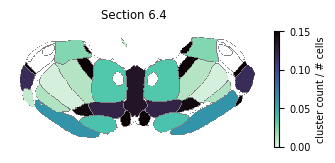

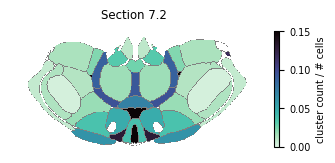

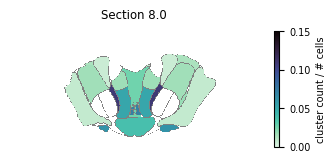

In [55]:
# plot the cell type counts in the CCF structures
figs_clust_count_norm2cells = cplots.plot_metrics_ccf(ccf_images, 
                                    th_ccf_metrics['count_norm2cells_cluster'], 
                                    sections_3,
                                    vmin=0, vmax=0.15, cmap=cmap,
                                    cb_label='cluster count / # cells'
                                    )

for i, fig in enumerate(figs_clust_count_norm2cells):
    fig.set_size_inches(4, 2)
    fig.savefig(f'../results/fig2D_ccf_cluster_count_norm2cells_sec{int(sections_3[i]*10)}.png',
                transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(f'../results/fig2D_ccf_cluster_count_norm2cells_colorbar.pdf',
                transparent=True, bbox_inches='tight')

In [43]:
local_isi_df = divmet.calculate_local_diversity_metric(obs_erode, 
                                                       divmet.inverse_simpsons_index, 
                                                       metric_name='isi', 
                                                       n_neighbors=15)

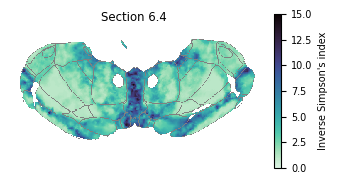

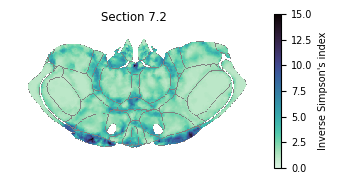

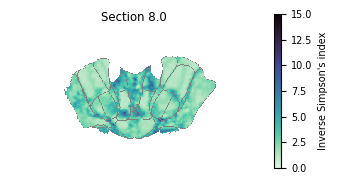

In [58]:
sections_3 = [6.4, 7.2, 8.0]
metric_name = 'local_isi_cluster'
for section in sections_3:
    fig = dplot.plot_local_metric_ccf_section(obs_erode, local_isi_df, ccf_images,
                                              section, metric_name, cmap=cmap)

    fig.set_size_inches(4, 2)
    fig.savefig(f'../results/fig2E_ccf_local_isi_cluster_sec{int(section*10)}.png',
                transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(f'../results/fig2E_ccf_local_isi_cluster_colorbar.pdf',
                transparent=True, bbox_inches='tight')